In [2]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using KernelDensity
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using DSP

In [3]:
include("../model-41/likelihood.jl")
include("../model-41/utill_model.jl")
include("../utill.jl")

plot_projections (generic function with 1 method)

In [4]:
function hist_2d(smpls, dim_1, dim_2; nbins=40, axmin = true, axmax=true)
    smpl_tmp, smpl_w = flatview(unshaped.(smpls.v)), smpls.weight
    if axmin == true
        hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), nbins=nbins)
    else
       hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), (range(axmin[1], stop=axmax[1], length=nbins), range(axmin[2], stop=axmax[2], length=nbins))) 
    end
    hist_tmp = normalize(hist_tmp, mode=:pdf) 
    return hist_tmp
end

hist_2d (generic function with 1 method)

In [5]:
β1 = 0.015
β2 = 0.0077 # (0.8/30/sqrt(12))
β3 = 0.0058 # (0.8/40/sqrt(12))

# flat prior for the pixel size
prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.06, 0.19), truncated(Normal(0.2, 0.04), 0.06, 0.19)],
        tr_size_2 = [truncated(Normal(0.2, 0.04), 0.06, 0.19), truncated(Normal(0.2, 0.04), 0.06, 0.19)],
        ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 7.0), truncated(Normal(4.0, 2.0), 4.0, 7.0)],
        ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 4.0), truncated(Normal(4.0, 2.0), 1.0, 4.0)],
        mixt_pow =  0.50 .. 1.0 ,
        waist = [truncated(Normal(2.9, 0.03), 2.65, 3.5)],
        waist_2 = [truncated(Normal(2.9, 0.03), 2.65, 3.5)], # 11
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [1, 1, 1], # 23, 24, 25, 
        resy = [1, 1, 1], # 26,27, 28, 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [27.1, 21.6, 114.0], # 31, 32, 33
        psy = [30.5, 23.4, 125.0], # 34, 35, 36
        cam4_psx = 121.8, # 37
        cam4_psy = 120.0, # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
    )

labels = [L"\sigma_x", L"\sigma_y", L"\sigma_x", L"\sigma_y", L"\sigma'_x", L"\sigma'_y", L"\sigma'_x", L"\sigma'_y", L"\alpha", L"s", L"s",
    L"\mu_x", L"\mu_x", L"\mu_x", L"\mu_x", L"\mu_y", L"\mu_y", L"\mu_y", L"\mu_y", 
    "ped", "lf", "a", 
    "res x", "res x", "res x", "res y", "res y", "res y", "res x", "res y", 
    "ps x", "ps x", "ps x", "ps y", "ps y", "ps y", "ps x", "ps y", 
    "la", "la", "la"
    ];

In [6]:
FPATH = "../../data/sampling_results/Benchmark-5/"

"../../data/sampling_results/Benchmark-5/"

In [7]:
readdir(FPATH)

68-element Array{String,1}:
 ".ipynb_checkpoints"
 "hc-1.hdf5"
 "hc-10.hdf5"
 "hc-11.hdf5"
 "hc-113.hdf5"
 "hc-12.hdf5"
 "hc-13.hdf5"
 "hc-14.hdf5"
 "hc-15.hdf5"
 "hc-16.hdf5"
 "hc-17.hdf5"
 "hc-18.hdf5"
 "hc-188.hdf5"
 ⋮
 "lc-343.hdf5"
 "lc-355.hdf5"
 "lc-369.hdf5"
 "lc-4.hdf5"
 "lc-48.hdf5"
 "lc-5.hdf5"
 "lc-6.hdf5"
 "lc-7.hdf5"
 "lc-8.hdf5"
 "lc-80.hdf5"
 "lc-9.hdf5"
 "tmp-lc-299.hdf5"

In [8]:
filename = readdir(FPATH)[18]
smpl_tmp = bat_read(FPATH*filename)
samples = varshape(prior).(smpl_tmp);

In [9]:
filename

# Example HC "hc-2.hdf5"
# Example LC "lc-169.hdf5"

"hc-3.hdf5"

In [10]:
smpl_vect = mode(samples)[1]

(tr_size = [0.09086308450460798, 0.12658441162203474], tr_size_2 = [0.13390583795496214, 0.1527712619433247], ang_spr = [6.1088689641573986, 5.823487091214878], ang_spr_2 = [2.3858104495125074, 2.3379950539783327], mixt_pow = 0.6949638211176246, waist = [3.1626108778378996], waist_2 = [2.8782580677675202], algmx = [33.473755229319046, 34.134866170774934, 21.203153291458122, 35.50076185570665], algmy = [36.903046334697315, 37.37653707545094, 19.969050159013683, 33.782293994577486], cam4_ped = 26.506084452281538, cam4_light_fluct = 1.3263663980588984, cam4_light_amp = 8.94596173316346, resx = [1, 1, 1], resy = [1, 1, 1], cam4_resx = 5.102337211971071, cam4_resy = 4.693805743772944, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [8.530243643578938, 11.190580752851607, 2.7030108883058825], s_cam = [0.0, 1.478, 15.026, 23.115])

In [11]:
# hist_tmp = hist_2d(samples, 1,2, nbins=40,)

# valss = sort([hist_tmp.weights...])
# valss_rc = valss ./ sum(valss)
# intt = [0.0001, 0.001, 0.006, 0.9999, 1]
# cvals = unique([valss[argmin(abs.(valss_rc .- i))] for i in intt])

# fig, ax= plt.subplots(1,1, figsize=(6,6))

# ax.contourf(
#     midpoints(hist_tmp.edges[1]), 
#     midpoints(hist_tmp.edges[2]), 
#     hist_tmp.weights', 
#     levels= 4, #cvals, 
#     cmap="Blues", alpha=0.6, antialiased=true) 

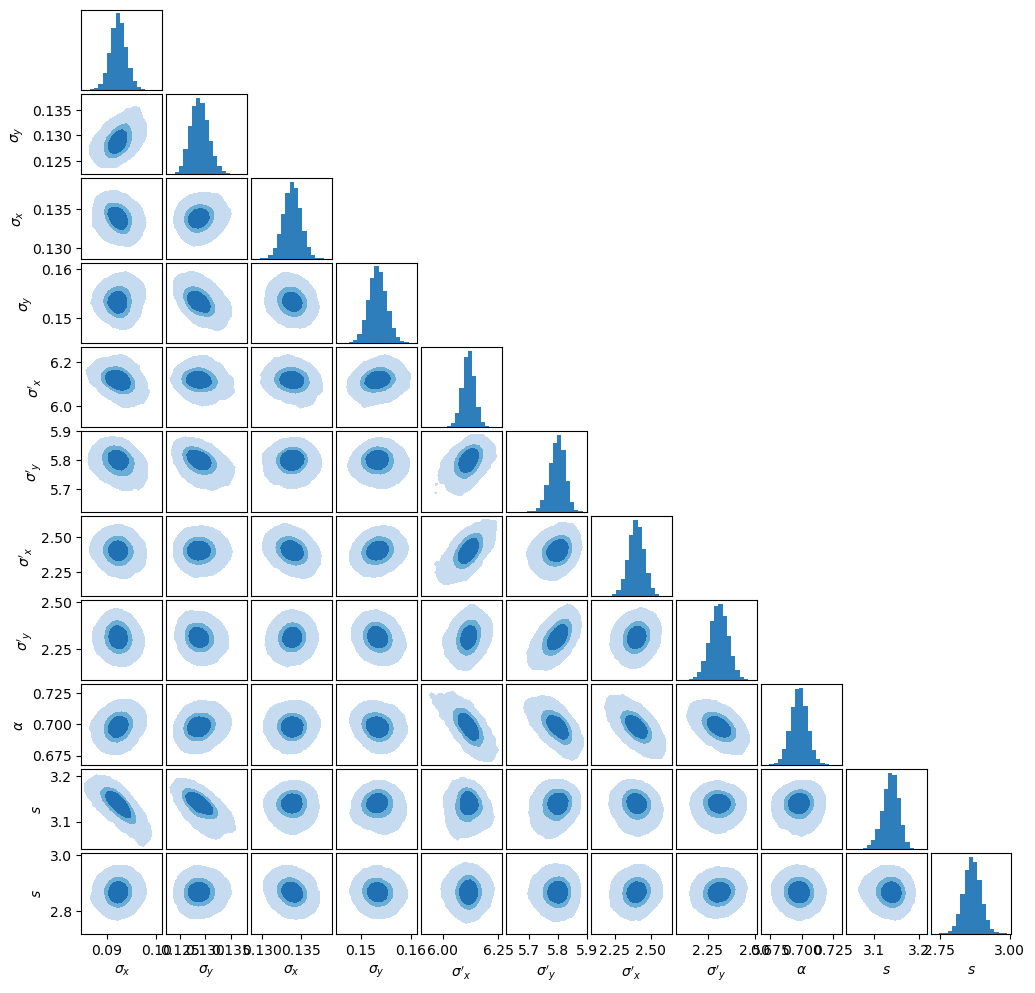

In [12]:
dims = [1,2,3,4,5,6,7,8,9,10, 11]
names = labels[dims]
levels = [0.0001, 0.65, 0.9, 0.95,  1,]
# levels = [0.001, 0.65, 0.95, 1,]
figsize = (12,12)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

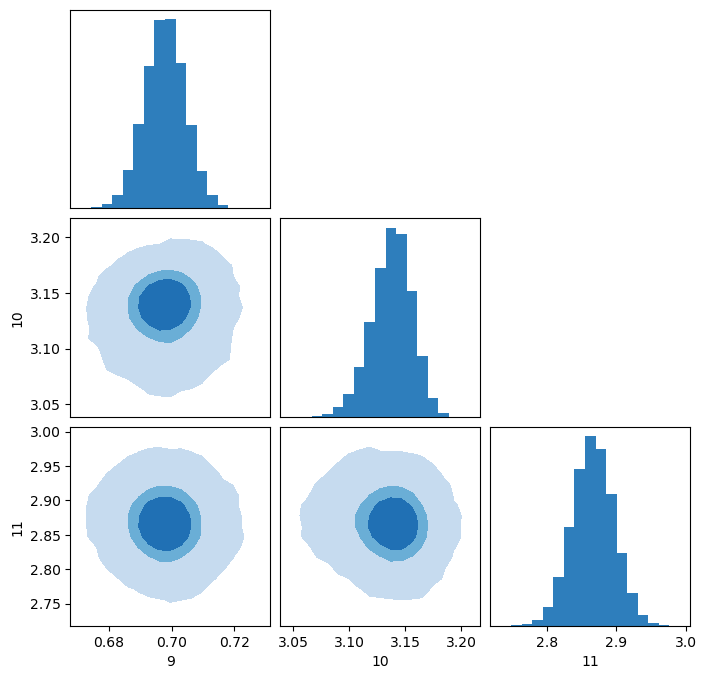

In [13]:
dims = [9,10,11,]
names = [9,10,11,]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
# levels = [0.01, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

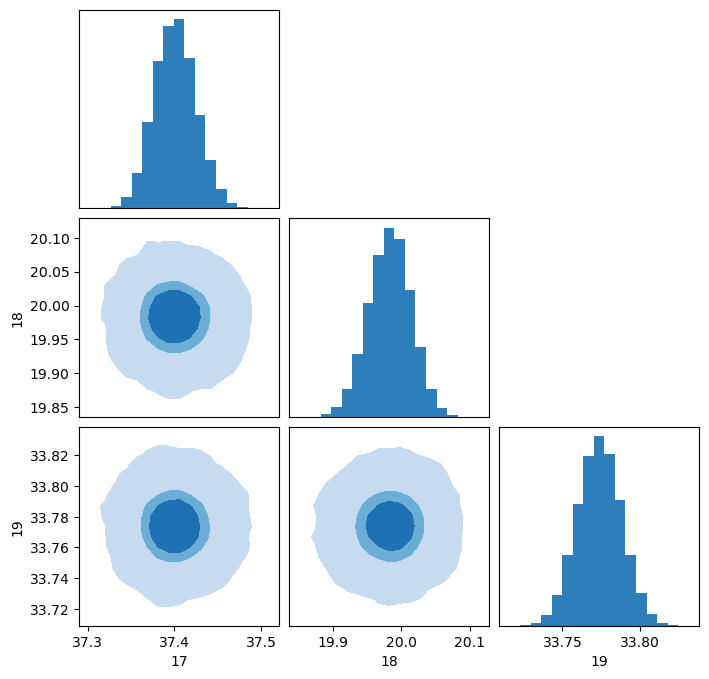

In [14]:
dims = [17,18,19]
names = [17,18,19]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
# levels = [0.01, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

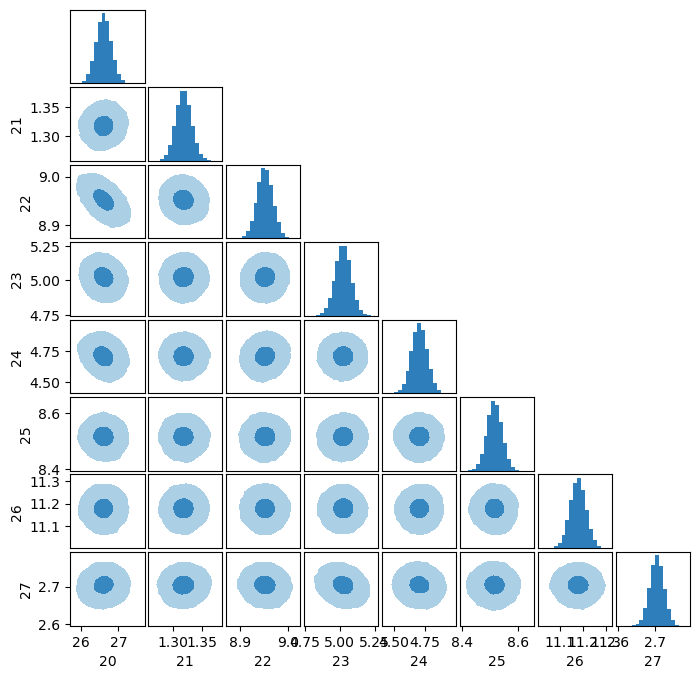

In [15]:
dims = [20,21,22,23,24,25,26,27]
names = [20,21,22,23,24,25,26,27]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.01, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [16]:
dims = [28,29,30,31,32,33,34,35]
names = [28,29,30,31,32,33,34,35]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
# levels = [0.01, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

LoadError: BoundsError: attempt to access 27×928943 Array{Float64,2} at index [28, 1:928943]

In [17]:
dims = [36,37,38]
names = [36,37,38]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
# levels = [0.01, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

LoadError: BoundsError: attempt to access 27×928943 Array{Float64,2} at index [36, 1:928943]

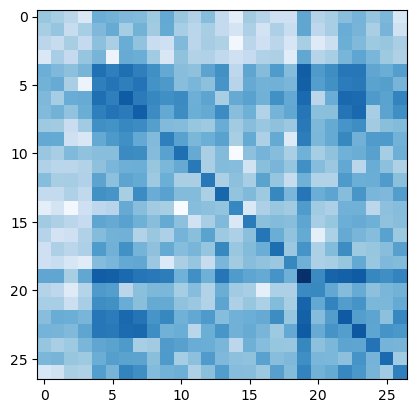

PyObject <matplotlib.image.AxesImage object at 0x7f9c35726ee0>

In [18]:
plt.imshow(log.(abs.(cov(flatview(unshaped.(samples.v))'))), cmap="Blues")

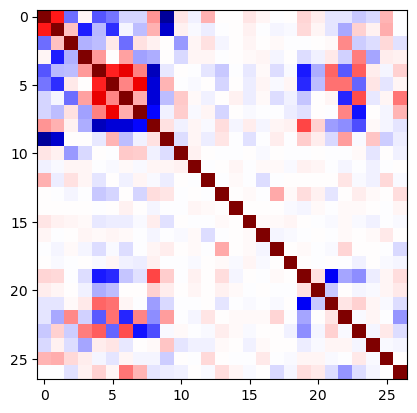

PyObject <matplotlib.image.AxesImage object at 0x7f9c29785ca0>

In [19]:
dt_reg = flatview(unshaped.(samples.v)) ./ std(flatview(unshaped.(samples.v)), dims=2)
dt_reg = dt_reg .- mean(dt_reg, dims=2)
dt_reg = cov(dt_reg')
max = maximum(abs.(dt_reg))

plt.imshow(dt_reg, cmap="seismic", vmin=-max, vmax=max)

In [20]:
if filename[1:2] == "hc"
    
    conv_mat = load("../../data/experiment/dataset_2/m2/conv-matrix-upd-2.jld2") 

    global conv_matrices = (
        cam_1 = conv_mat["cam_1"],
        cam_2 = conv_mat["cam_2"],
        cam_3 = conv_mat["cam_3"],
        cam_4 = conv_mat["cam_4"], 
    ) 

    images = load("../../data/experiment/dataset_2/m2/images-satur.jld2")
    event_number = parse(Int64, filename[4:end-5])

    global event = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    );
    
    images = load("../../data/experiment/dataset_2/m2/images.jld2")

    global event_nt = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    );
end

(cam_1 = [36.0 13.0 … 0.0 268.0; 7.0 0.0 … 0.0 0.0; … ; 5.0 12.0 … 1.0 198.0; 21.0 11.0 … 0.0 0.0], cam_2 = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 1.0], cam_3 = [30.0 48.0 … 24.0 60.0; 0.0 0.0 … 3.0 0.0; … ; 0.0 0.0 … 4.0 0.0; 49.0 6.0 … 0.0 0.0], cam_4 = [22.0 17.0 … 23.0 15.0; 17.0 17.0 … 43.0 16.0; … ; 16.0 16.0 … 25.0 17.0; 18.0 18.0 … 17.0 21.0], population = 26.78569984436035)

In [21]:
if filename[1:2] == "lc"
    @show "true"
    conv_mat = load("../../data/experiment/dataset_2/m1/conv-matrix-upd-2.jld2") 

    global conv_matrices = (
        cam_1 = conv_mat["cam_1"],
        cam_2 = conv_mat["cam_2"],
        cam_3 = conv_mat["cam_3"],
        cam_4 = conv_mat["cam_4"], 
    ) 

    images = load("../../data/experiment/dataset_2/m1/images-satur.jld2")
    event_number = parse(Int64, filename[4:end-5])

    global event = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    )
    
    images = load("../../data/experiment/dataset_2/m1/images.jld2")

    global event_nt = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    );

end

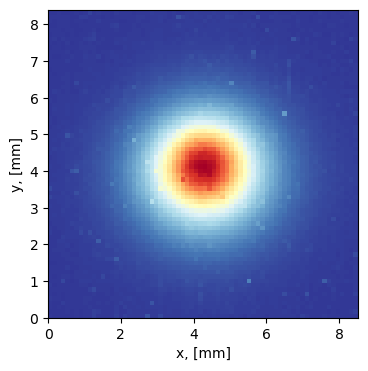

PyObject Text(24.0, 0.5, 'y, [mm]')

In [34]:
param_truth = (
    tr_size = [0.15, 0.15], 
    tr_size_2 = [0.10, 0.10], 
    ang_spr = [6, 6], 
    ang_spr_2 = [3, 3], 
    mixt_pow = 0.7, 
    waist = [3.15], 
    waist_2 = [2.9], 
    algmx = [36.0, 37.0, 19.0, 33.0], 
    algmy = [33.0, 34.0, 21.0, 35.0], 
    cam4_ped = 26.0, 
    cam4_light_fluct = 1.50, 
    cam4_light_amp = 8.90, 
    resx = [1, 1, 1], 
    resy = [1, 1, 1], 
    cam4_resx = 3.0, 
    cam4_resy = 3.0, 
    psx = [27.1, 21.6, 114.0], 
    psy = [30.5, 23.4, 125.0], 
    cam4_psx = 121.8, 
    cam4_psy = 120.0, 
    light_amp = [8.5, 11.1, 2.5], 
    s_cam = [0.0, 1.478, 15.026, 23.115]
);

fig, ax = plt.subplots(1,1, figsize=(4,4))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax.pcolormesh(range(0, length = 71, step=param_truth.cam4_psx*10^-3), range(0, length = 71, step=param_truth.cam4_psy*10^-3), event_nt.cam_4, cmap="RdYlBu_r")
# ax[1,2].pcolormesh(range(0, length = 71, step=param_truth.psx[2]*10^-3), range(0, length = 71, step=param_truth.psy[2]*10^-3), event.cam_2, cmap="RdYlBu_r")
# ax[2,1].pcolormesh(range(0, length = 41, step=param_truth.psx[3]*10^-3), range(0, length = 41, step=param_truth.psy[3]*10^-3), event.cam_3, cmap="RdYlBu_r")
# ax[2,2].pcolormesh(range(0, length = 71, step=param_truth.cam4_psx*10^-3), range(0, length = 71, step=param_truth.cam4_psy*10^-3), event.cam_4, cmap="RdYlBu_r")

# ax[1,1].text(0.75,0.9,"Cam. 1", transform=ax[1].transAxes, color="white", )
# ax[1,2].text(0.75,0.9,"Cam. 2", transform=ax[1,2].transAxes, color="white",)
# ax[2,1].text(0.75,0.9,"Cam. 3", transform=ax[2,1].transAxes, color="white",)
# ax[2,2].text(0.75,0.9,"Cam. 4", transform=ax[2,2].transAxes, color="white",)

ax.set_xlabel("x, [mm]")
ax.set_ylabel("y, [mm]")

# ax[2,1].set_xlabel("x, [mm]")
# ax[2,2].set_xlabel("x, [mm]")

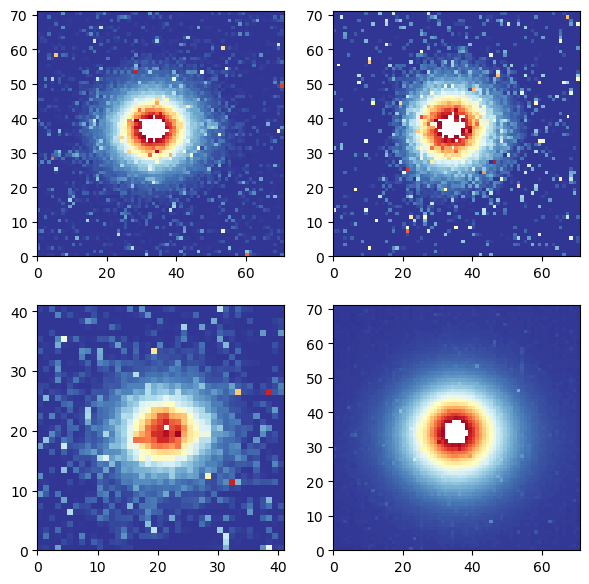

PyObject <matplotlib.collections.QuadMesh object at 0x7f9c297391c0>

In [22]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(event.cam_1, cmap="RdYlBu_r")
ax[1,2].pcolormesh(event.cam_2, cmap="RdYlBu_r")
ax[2,1].pcolormesh(event.cam_3, cmap="RdYlBu_r")
ax[2,2].pcolormesh(event.cam_4, cmap="RdYlBu_r")



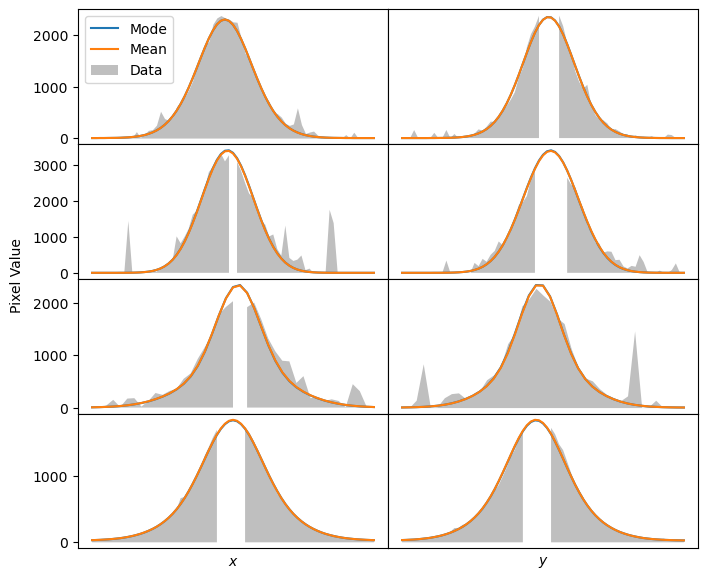

PyObject Text(0.04, 0.5, 'Pixel Value')

In [82]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_crossections(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

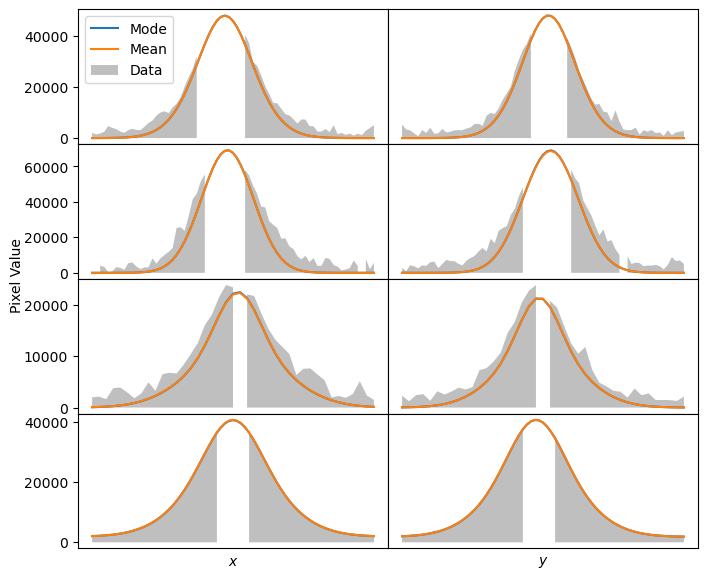

PyObject Text(0.04, 0.5, 'Pixel Value')

In [83]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_integral(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

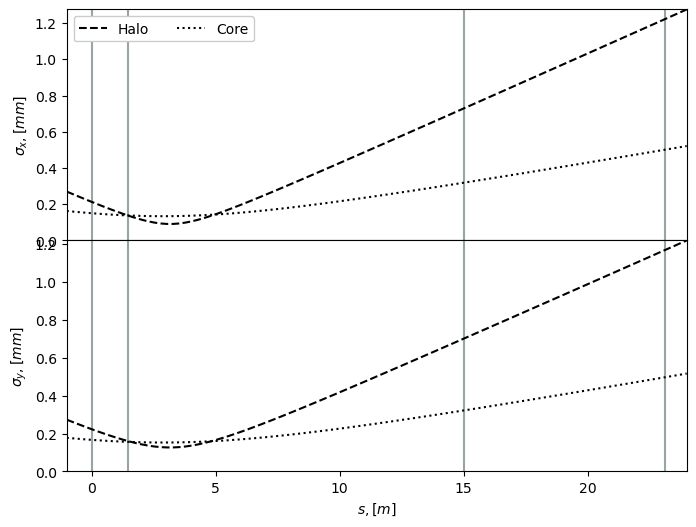

PyObject Text(0.5, 26.28125, '$s, [m]$')

In [84]:
params_array = [mode(samples)[1],]
colors_array = ["gray",]
labels_array = ["Truth", ]

plot_envelop_trajectory(params_array,  labels = labels_array, colors=colors_array)

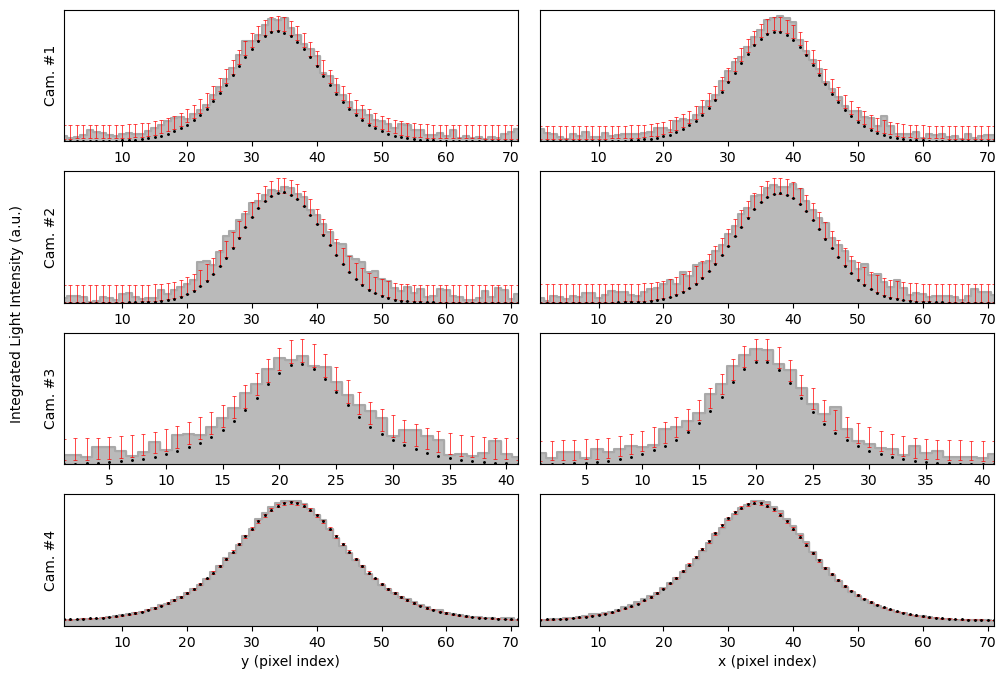

PyObject Text(0.08, 0.5, 'Integrated Light Intensity (a.u.)')

In [85]:
plot_projections(conv_matrices, event_nt, event_nt, params_array[1], isnontr = true)

In [86]:
function plot_sign_comp(params, cam_ind, npix)

    σ_x = sqrt.(params.tr_size[1]^2 + 10^-4*params.ang_spr[1]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 
    σ_x_2 = sqrt.(params.tr_size_2[1]^2 + 10^-4*params.ang_spr_2[1]^2*(params.waist_2[1] - params.s_cam[cam_ind])^2) 
        
    σ_y = sqrt.(params.tr_size[2]^2 + 10^-4*params.ang_spr[2]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 
    σ_y_2 = sqrt.(params.tr_size_2[2]^2 + 10^-4*params.ang_spr_2[2]^2*(params.waist_2[1] - params.s_cam[cam_ind])^2) 
    
    if cam_ind < 4
        x_bins = range(0, length = npix+1, step = params.psx[cam_ind]*10^-3)
        y_bins = range(0, length = npix+1, step = params.psy[cam_ind]*10^-3)
    else
        x_bins = range(0, length = npix+1, step = params.cam4_psx*10^-3)
        y_bins = range(0, length = npix+1, step = params.cam4_psy*10^-3)
    end
    
    mue_x = maximum(x_bins) / 2
    mue_y = maximum(y_bins) / 2
    
    vals_x_1 = diff(cdf.(Normal(mue_x, σ_x), x_bins))
    vals_x_2 = diff(cdf.(Normal(mue_x, σ_x_2), x_bins))
    
    vals_y_1 = diff(cdf.(Normal(mue_y, σ_y), y_bins))
    vals_y_2 = diff(cdf.(Normal(mue_y, σ_y_2), y_bins))

    
    fig, ax = plt.subplots(2,1, figsize=(7,5), )
    fig.subplots_adjust(hspace=0.4, wspace=0.2)
    
    
    ax[1].plot(x_bins[1:end-1], params.mixt_pow .* vals_x_1, color="k", ls="--", label="Halo")
    ax[1].plot(x_bins[1:end-1], (1-params.mixt_pow).*vals_x_2, color="k", ls=":", label="Core")
    ax[1].plot(x_bins[1:end-1], (1-params.mixt_pow).*vals_x_2 .+ params.mixt_pow .* vals_x_1, color="red", label="Sum")
    ax[1].legend(loc="upper right")
    
    
    ax[2].plot(y_bins[1:end-1], params.mixt_pow .* vals_y_1, color="k", ls="--")
    ax[2].plot(y_bins[1:end-1], (1-params.mixt_pow).*vals_y_2, color="k", ls=":")
    ax[2].plot(y_bins[1:end-1], (1-params.mixt_pow).*vals_y_2 .+ params.mixt_pow .* vals_y_1, color="red")
    
    ax[1].set_xlabel(L"\mathrm{x \; (mm)}")
    ax[2].set_xlabel(L"\mathrm{y \; (mm)}")
end

plot_sign_comp (generic function with 1 method)

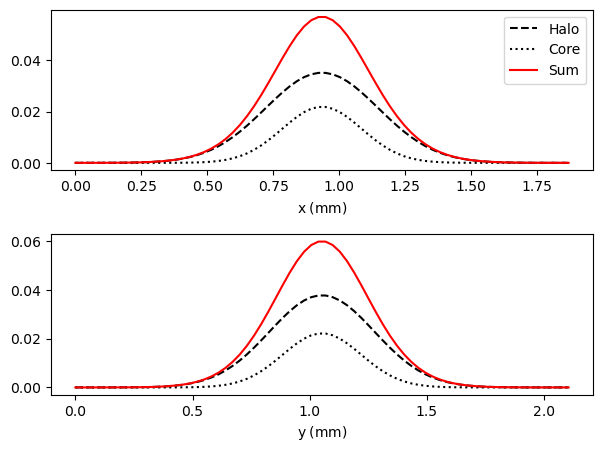

PyObject Text(0.5, 28.0, '$\\mathrm{y \\; (mm)}$')

In [87]:
plot_sign_comp(params_array[1], 1, 70)

In [88]:
function plot_signal_envelope(params)
    
    color_1 = "sandybrown"
    color_2 = "lightsteelblue"
    
    size = (10, 8)
    
    fig = plt.figure(figsize=size,)

    fig.subplots_adjust(hspace=0.00, wspace=0.00)

    r11 = plt.subplot2grid((13, 4), (0, 0), rowspan=3, colspan=1, yticks=[],  xticks=[], )
    r12 = plt.subplot2grid((13, 4), (0, 1), rowspan=3, colspan=1, yticks=[],  xticks=[], )
    r13 = plt.subplot2grid((13, 4), (0, 2), rowspan=3, colspan=1, yticks=[],  xticks=[], )
    r14 = plt.subplot2grid((13, 4), (0, 3), rowspan=3, colspan=1, yticks=[],  xticks=[], )
    rst1 = [r11, r12, r13, r14]

    r2 = plt.subplot2grid((13, 4), (3, 0), rowspan=3, colspan=4, )
    r2.tick_params(axis="x", pad=8)
    r3 = plt.subplot2grid((13, 4), (7, 0), rowspan=3, colspan=4, xticklabels=[], )

    r3.xaxis.tick_top()

    r41 = plt.subplot2grid((13, 4), (10, 0), rowspan=3, colspan=1, yticks=[],  xticks=[], )
    r42 = plt.subplot2grid((13, 4), (10, 1), rowspan=3, colspan=1, yticks=[],  xticks=[], )
    r43 = plt.subplot2grid((13, 4), (10, 2), rowspan=3, colspan=1, yticks=[],  xticks=[], )
    r44 = plt.subplot2grid((13, 4), (10, 3), rowspan=3, colspan=1, yticks=[],  xticks=[], )
    rst2 = [r41, r42, r43, r44]
    
    # make plot
    
    x_range = range(-1, stop = 24, length=100)
    σ_x(x) = sqrt.(params.tr_size[1]^2 + 10^-4*params.ang_spr[1]^2*(params.waist[1] - x)^2) 
    σ_x_2(x) = sqrt.(params.tr_size_2[1]^2 + 10^-4*params.ang_spr_2[1]^2*(params.waist_2[1] - x)^2) 

    σ_y(x) = sqrt.(params.tr_size[2]^2 + 10^-4*params.ang_spr[2]^2*(params.waist[1] - x)^2) 
    σ_y_2(x) = sqrt.(params.tr_size_2[2]^2 + 10^-4*params.ang_spr_2[2]^2*(params.waist_2[1] - x)^2) 

    σ_x_vals = [σ_x(x) for x in x_range]
    σ_y_vals = [σ_y(x) for x in x_range]

    σ_x_vals_2 = [σ_x_2(x) for x in x_range]
    σ_y_vals_2 = [σ_y_2(x) for x in x_range]
    
    r2.fill_between(x_range, σ_x_vals, color=color_1, alpha=0.5, )
    r3.fill_between(x_range, σ_y_vals, color=color_1, alpha=0.5, label="Halo Component")
            
    r2.fill_between(x_range, σ_x_vals_2, color=color_2, alpha=0.5, )
    r3.fill_between(x_range, σ_y_vals_2, color=color_2, alpha=0.5, label="Core Component")
    r3.legend(bbox_to_anchor=(0.2, 0.01, 0.4, 0.15), ncol=2, framealpha=0.0)
    
    r2.axvline(params.s_cam[1], linestyle=":", color="darkslategray", alpha=0.5, label="Cam. Position")
    r2.axvline(params.s_cam[2], linestyle=":", color="darkslategray", alpha=0.5)
    r2.axvline(params.s_cam[3], linestyle=":", color="darkslategray", alpha=0.5)
    r2.axvline(params.s_cam[4], linestyle=":", color="darkslategray", alpha=0.5)
            
    r3.axvline(params.s_cam[1], linestyle=":", color="darkslategray", alpha=0.5)
    r3.axvline(params.s_cam[2], linestyle=":", color="darkslategray", alpha=0.5)
    r3.axvline(params.s_cam[3], linestyle=":", color="darkslategray", alpha=0.5)
    r3.axvline(params.s_cam[4], linestyle=":", color="darkslategray", alpha=0.5)
    
    r2.axvline(params.waist[1], linestyle="-", color=color_1, alpha=1, label="Waist Halo")
    r3.axvline(params.waist[1], linestyle="-", color=color_1, alpha=1)
    r2.axvline(params.waist_2[1], linestyle="-", color=color_2, alpha=1, label="Waist Core")
    r3.axvline(params.waist_2[1], linestyle="-", color=color_2, alpha=1)
    
    r2.axvline(2.9, linestyle=":", color="red", alpha=1, label="Waist Expected")
    r3.axvline(2.9, linestyle=":", color="red", alpha=1, label="Expected")
    
    r2.legend(bbox_to_anchor=(0.6, 0.98,), ncol=2, framealpha=0.0)
    
    for i in 1:4
        if i < 4
            npix = i < 3 ? 71 : 41
            x_bins = range(0, length = npix+1, step = params.psx[i]*10^-3)
            y_bins = range(0, length = npix+1, step = params.psy[i]*10^-3)
                
            mue_x = maximum(x_bins) / 2
            mue_y = maximum(y_bins) / 2
            
            σ_x_vls = σ_x(params.s_cam[i])
            σ_x_2_vls = σ_x_2(params.s_cam[i])
            
            σ_y_vls = σ_y(params.s_cam[i])
            σ_y_2_vls = σ_y_2(params.s_cam[i])
    
            vals_x_1 = diff(cdf.(Normal(mue_x, σ_x_vls), x_bins))
            vals_x_2 = diff(cdf.(Normal(mue_x, σ_x_2_vls), x_bins))

            vals_y_1 = diff(cdf.(Normal(mue_y, σ_y_vls), y_bins))
            vals_y_2 = diff(cdf.(Normal(mue_y, σ_y_2_vls), y_bins))
            
            rst1[i].fill_between(x_bins[1:end-1], params.mixt_pow .* vals_x_1, color=color_1, alpha=0.5, label="Halo")
            rst1[i].fill_between(x_bins[1:end-1], (1-params.mixt_pow).*vals_x_2, color=color_2, alpha=0.5, label="Core")
            rst1[i].plot(x_bins[1:end-1], (1-params.mixt_pow).*vals_x_2 .+ params.mixt_pow .* vals_x_1, color="k", ls="--", label="Sum")
            
            rst2[i].fill_between(y_bins[1:end-1], params.mixt_pow .* vals_y_1, alpha=0.5, color=color_1, )
            rst2[i].fill_between(y_bins[1:end-1], (1-params.mixt_pow).*vals_y_2, alpha=0.5, color=color_2, )
            rst2[i].plot(y_bins[1:end-1], (1-params.mixt_pow).*vals_y_2 .+ params.mixt_pow .* vals_y_1, color="k", ls="--")
            
        else
            npix = 71
            x_bins = range(0, length = npix+1, step = params.cam4_psx*10^-3)
            y_bins = range(0, length = npix+1, step = params.cam4_psy*10^-3)
            
            mue_x = maximum(x_bins) / 2
            mue_y = maximum(y_bins) / 2
            
            σ_x_vls = σ_x(params.s_cam[i])
            σ_x_2_vls = σ_x_2(params.s_cam[i])
            
            σ_y_vls = σ_y(params.s_cam[i])
            σ_y_2_vls = σ_y_2(params.s_cam[i])
    
            vals_x_1 = diff(cdf.(Normal(mue_x, σ_x_vls), x_bins))
            vals_x_2 = diff(cdf.(Normal(mue_x, σ_x_2_vls), x_bins))

            vals_y_1 = diff(cdf.(Normal(mue_y, σ_y_vls), y_bins))
            vals_y_2 = diff(cdf.(Normal(mue_y, σ_y_2_vls), y_bins))
            
            rst1[i].fill_between(x_bins[1:end-1], params.mixt_pow .* vals_x_1, color=color_1, alpha=0.5, label="Halo")
            rst1[i].fill_between(x_bins[1:end-1], (1-params.mixt_pow).*vals_x_2, color=color_2, alpha=0.5, label="Core")
            rst1[i].plot(x_bins[1:end-1], (1-params.mixt_pow).*vals_x_2 .+ params.mixt_pow .* vals_x_1, color="k",  ls="--", label="Sum")
            
            rst2[i].fill_between(y_bins[1:end-1], params.mixt_pow .* vals_y_1, color=color_1, alpha=0.5, )
            rst2[i].fill_between(y_bins[1:end-1], (1-params.mixt_pow).*vals_y_2, color=color_2, alpha=0.5, )
            rst2[i].plot(y_bins[1:end-1], (1-params.mixt_pow).*vals_y_2 .+ params.mixt_pow .* vals_y_1, color="k", ls="--")
            
        end
    end
    
    r2.text(0.015,0.62,"Cam. 1", rotation="vertical", color="darkslategray", transform=r2.transAxes) 
    r2.text(0.075,0.62,"Cam. 2", rotation="vertical", color="darkslategray", transform=r2.transAxes) 
    r2.text(0.62,0.62,"Cam. 3", rotation="vertical", color="darkslategray", transform=r2.transAxes) 
    r2.text(0.94,0.62,"Cam. 4", rotation="vertical", color="darkslategray", transform=r2.transAxes) 
    
    r11.text(0.04,0.89,"Cam. 1", color="darkslategray", transform=r11.transAxes)
    r12.text(0.04,0.89,"Cam. 2", color="darkslategray", transform=r12.transAxes)
    r13.text(0.04,0.89,"Cam. 3", color="darkslategray", transform=r13.transAxes)
    r14.text(0.04,0.89,"Cam. 4", color="darkslategray", transform=r14.transAxes)

    fig.text(0.92, 0.25, "Projection Y", rotation="vertical")
    fig.text(0.92, 0.65, "Projection X", rotation="vertical")
    
    r2.set_ylabel(L"\sigma_x \;(mm)")
    r3.set_ylabel(L"\sigma_y \;(mm)")
    
    r2.set_xlim(-1, maximum(x_range))
    r3.set_xlim(-1, maximum(x_range))
    
    max_sigma = maximum([maximum(σ_x_vals), maximum(σ_y_vals), maximum(σ_x_vals_2), maximum(σ_y_vals_2)])
    
    r2.set_ylim(bottom=0.0, top = max_sigma)
    r3.set_ylim(bottom=0.0, top = max_sigma)
    r3.invert_yaxis()

    r11.set_ylim(bottom=0.0)
    r12.set_ylim(bottom=0.0)
    r13.set_ylim(bottom=0.0)
    r14.set_ylim(bottom=0.0)

    r41.set_ylim(bottom=0.0)
    r42.set_ylim(bottom=0.0)
    r43.set_ylim(bottom=0.0)
    r44.set_ylim(bottom=0.0)
     
end

plot_signal_envelope (generic function with 1 method)

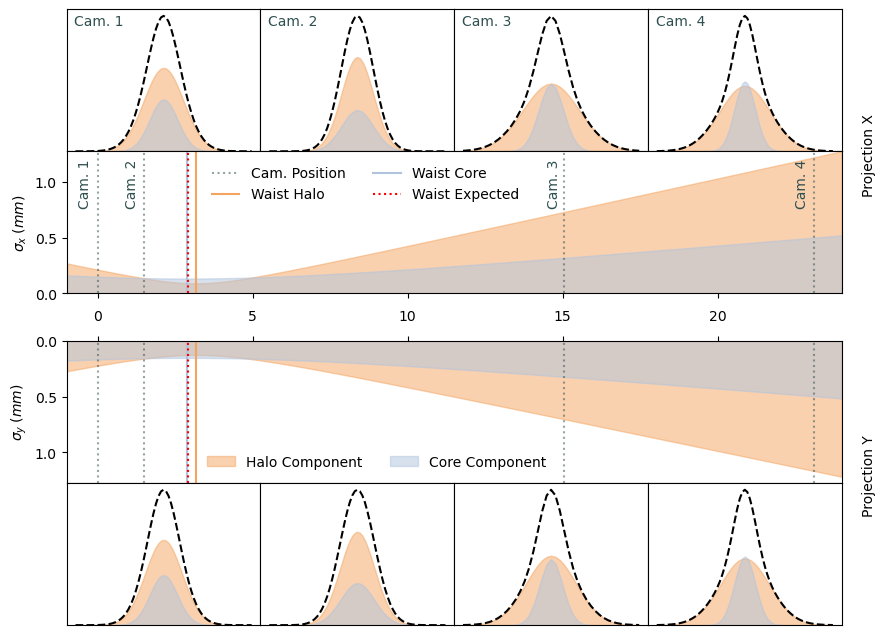

(0.0, 0.06064043646494316)

In [89]:
plot_signal_envelope(params_array[1])